## Introduction to ANN - Exercise
---
Instructions are given in <span style="color:blue">blue</span> color.

Here, there really is just one task: Repeat the training part of the notebook we used in class replacing the MNIST dataset with [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), but also do some experimentation with the MLP-Parameters:
* $n_h$: number of hidden layers,
* $m_j,\>j=1,\dots,n_h$: number of neurons in the $j$-th hidden layer,
* and other hyperparameters that have an impact on performance and training time.

### CIFAR-10

The CIFAR-10 dataset consists of $32 \times 32 \times 3$ RGB pixel images, where each pixel is represented by a RGB value. The third dimension (or *channel* in the case of image data) represents the color value. Therefore, we have $32\times32\times3=3072$ *features* per row. The images are then *unrolled* (or flattened) into vectors of length $3072$ and each one (in both the training set and the test set) is given a *class label* of $0-9$ corresponding to the type of class it represents (where the number corresponds to the alphabetic ordering of the classes).

You fill find the dataset publicly available on [Alex Krizhevsky's Homepage](https://www.cs.toronto.edu/~kriz/cifar.html). To load the data you can use an *adaptation* of the following code from [Matt Petersen](https://mattpetersen.github.io/load-cifar10-with-numpy). Either specify a path and the data will automatically be downloaded, or download the binary version of the data beforehand.
This is done with the following code along with some restructuring in order to be able to work with the data in very much the same way we did with MNIST in class.

**Note**: It might actually take a while to execute the next couple of code cells, especially if the data needs to be downloaded first. Just be patient.

In [124]:
"""Load from /home/USER/data/cifar10 or elsewhere; download if missing."""

import tarfile
import os
from urllib.request import urlretrieve
import numpy as np


def cifar10(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing CIFAR-10. Default is
            /home/USER/data/cifar10 or C:\Users\USER\data\cifar10.
            Create if nonexistant. Download CIFAR-10 if missing.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values,
            with the order (red -> blue -> green). Columns of labels are a
            onehot encoding of the correct class.
    """
    url = 'https://www.cs.toronto.edu/~kriz/'
    tar = 'cifar-10-binary.tar.gz'
    files = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']

    if path is None:
        # Set path to /home/USER/data/cifar10 or C:\Users\USER\data\cifar10
        path = os.path.join(os.path.expanduser('~'), 'data', 'cifar10')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download tarfile if missing
    if tar not in os.listdir(path):
        urlretrieve(''.join((url, tar)), os.path.join(path, tar))
        print("Downloaded %s to %s" % (tar, path))

    # Load data from tarfile
    with tarfile.open(os.path.join(path, tar)) as tar_object:
        # Each file contains 10,000 color images and 10,000 labels
        fsize = 10000 * (32 * 32 * 3) + 10000

        # There are 6 files (5 train and 1 test)
        buffr = np.zeros(fsize * 6, dtype='uint8')

        # Get members of tar corresponding to data files
        # -- The tar contains README's and other extraneous stuff
        members = [file for file in tar_object if file.name in files]

        # Sort those members by name
        # -- Ensures we load train data in the proper order
        # -- Ensures that test data is the last file in the list
        members.sort(key=lambda member: member.name)

        # Extract data from members
        for i, member in enumerate(members):
            # Get member as a file object
            f = tar_object.extractfile(member)
            # Read bytes from that file object into buffr
            buffr[i * fsize:(i + 1) * fsize] = np.frombuffer(f.read(), 'B')

    # Parse data from buffer
    # -- Examples are in chunks of 3,073 bytes
    # -- First byte of each chunk is the label
    # -- Next 32 * 32 * 3 = 3,072 bytes are its corresponding image

    # Labels are the first byte of every chunk
    labels = buffr[::3073]

    # Pixels are everything remaining after we delete the labels
    pixels = np.delete(buffr, np.arange(0, buffr.size, 3073))
    images = pixels.reshape(-1, 3072).astype('float32') / 255

    # Split into train and test
    train_images, test_images = images[:50000], images[50000:]
    train_labels, test_labels = labels[:50000], labels[50000:]

    return train_images, train_labels, test_images, test_labels

In [125]:
X_train, y_train, X_test, y_test = cifar10('./data')
print(f'Train - Rows: {X_train.shape[0]}, columns: {X_train.shape[1]}')
print(f'Test - Rows: {X_test.shape[0]}, columns: {X_test.shape[1]}')

Train - Rows: 50000, columns: 3072
Test - Rows: 10000, columns: 3072


The CIFAR-10 data has a different structure than the MNIST data. To get the same structure as in the class example we need to switch some dimensions and reshape the array.

In [126]:
X_train = (np.moveaxis(X_train.reshape(50000,3,32,32),1,-1)).reshape(50000,3072)
X_test = (np.moveaxis(X_test.reshape(10000,3,32,32),1,-1)).reshape(10000,3072)

In [127]:
X_train.shape[1]

3072

To remove the color channel from our images we have to reshape a little differently.

In [128]:
# Calculating the mean of all 3 channels as the greyscale value:
X_train_g = np.mean(X_train.reshape(50000,32,32,3),-1).reshape(50000,1024)
X_test_g = np.mean(X_test.reshape(10000,32,32,3),-1).reshape(10000,1024)

In [129]:
X_train_g.shape[1]

1024

* <div style="color:blue">Let's get started with a little visualization task by displaying the 42nd image of each class present.</div>

**Hint**: Remember that you are working with an additional color dimension!

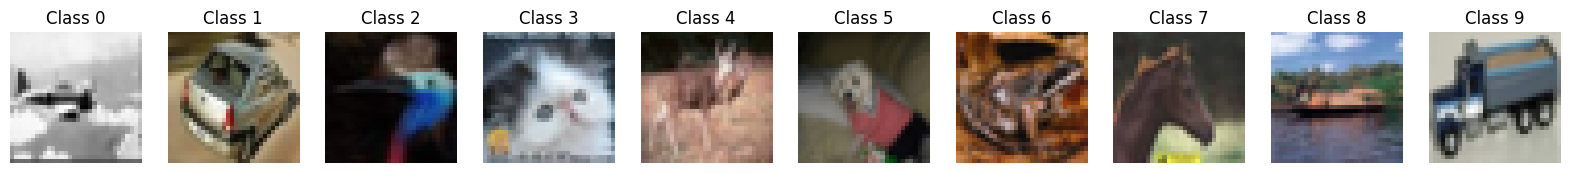

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10  # Import the CIFAR-10 dataset

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_labels = train_labels.flatten()

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
class_counts = np.zeros(10, dtype=int)

for i in range(len(train_labels)):
    label = train_labels[i]
    class_counts[label] += 1
    if class_counts[label] == 42:
        ax = axes[label]

        img = train_images[i].reshape(32, 32, 3)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Class {label}')

plt.show()


* <div style="color:blue">Visualize 25 different samples of the class representing dogs.</div>

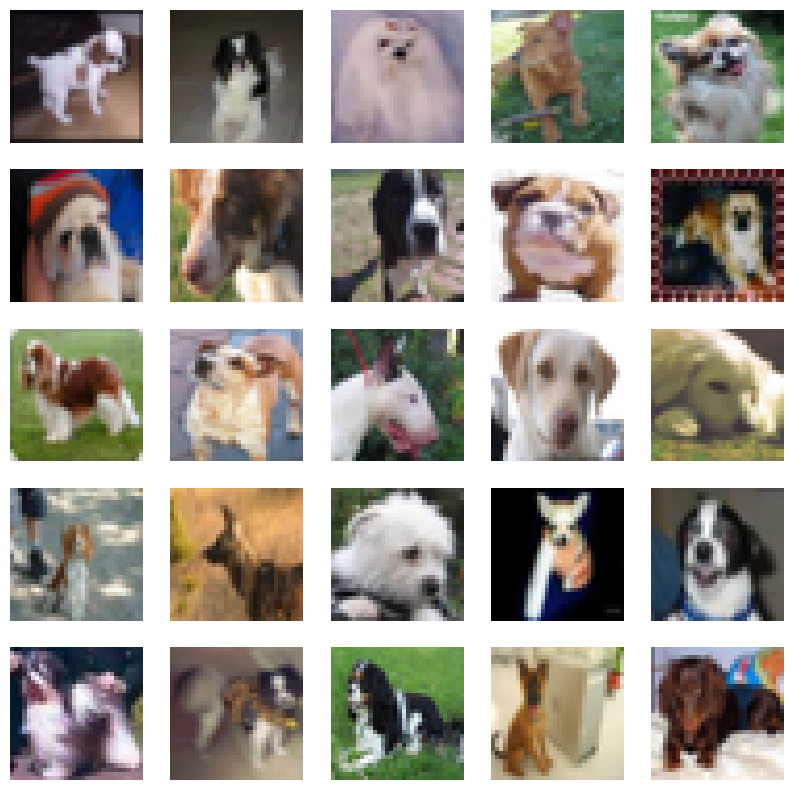

In [131]:
# Your solution goes here:
import numpy as np
import matplotlib.pyplot as plt
dog_indices = np.where(train_labels == 5)[0]
np.random.seed(0) 
selected_indices = np.random.choice(dog_indices, 25, replace=False)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 subplot for 25 images
axes = axes.flatten()  # Flatten the 2D array of axes to simplify the loop
for i, idx in enumerate(selected_indices):
    axes[i].imshow(train_images[idx])
    axes[i].axis('off')  # Turn off axis numbering
plt.show()

You are now asked to perform image classification using a multi-layer perceptron:

* <div style="color:blue">Use <code>scikit learn</code>'s <code>MLPClassifier</code> to train various models that specify</div>

    * <div style="color:blue">different numbers of hidden layers,</div>
    * <div style="color:blue">different numbers of neurons in the hidden layers,</div>
    * <div style="color:blue">different hyperparameters (see info below).</div>
* <div style="color:blue">For each of your model variants you should record</div>

    * <div style="color:blue">the time it took to train the network,</div>
    * <div style="color:blue">how many epochs were necessary,</div>
    * <div style="color:blue">how the loss values evolved over the epochs,</div>
    * <div style="color:blue">the accuracy of both training and test data.</div>
* <div style="color:blue">What is your <b>interpretation</b> of those experiments? Give a comment on the behaviour of the different MLP configurations.</div>

**Hints**: 
* The CIFAR-10 data is much more complex than MNIST (as seen in class). The image resolution is very small and the classes are much more *nuanced*. In order to successfully classify such data, you might need to tune some parameters of your model.
* Due to the bigger input size, training times might be much slower than you have seen in class. You absolutely should change some hyperparameters that have an impact on the training times (if you don't want to wait for hours). Here are some **ideas** you could try: 
    + `batch_size`: Larger batch sizes mean less gradient updates are computed, but calculating the gradient is more computationally expensive. So there is an inherent trade-off in the magnitude of batch sizes. Not only that, but different batch sizes will have an impact on model performance. Increasing the batch size might lead to a solution that is closer to the true global minimum (which can actually be undesired as the model loses its ability to generalize). On the other hand, decreasing the batch size might get the model stuck at a bad local minimum early on in the training process. For further information see [Goodfellow et al., 2016](http://www.deeplearningbook.org/contents/optimization.html).
    + `learning_rate`: Higher learning rates will reduce the model's convergence time, but can result in suboptimal weight updates towards the end of the learning process (which can lead to increased bias of the model).
    + `hidden_layer_sizes`: Reducing the number of layers and neurons will result in a less complex model and, therefore, faster training times. However, if the model is too simple, it might not be able to fit the data at hand, which results in low accuracy.
    + `max_iter`: You can force an early stop of the training process with this parameter. This is actually a valid strategy to prevent overfitting, but the model might not fit the data yet if you stop too early. Don't be shy to try really low values!
    + **Data Transformation**: Sometimes it can make sense to transform the data to improve training time. You can always train with less data of course, but this might lead to poor performance of the model. For the image classification task, you can also try to train with *greyscale* only, which would reduce input size by 2/3. Maybe the model is mostly invariant to the *color component*?
<br>
<br>
* If you want to see some more information during the training process, you can turn on the `verbose` parameter (recommended!).
* Getting *above* 50% Test-Accuracy in a short amount of training time would be a really good result! Can you do it?

In [132]:
# Your solution goes here: (if you need more code/markdown cells, feel free to insert them as you see fit)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from time import time

## Preparing the CIFAR-10 Data

In [133]:
X, y = fetch_openml('CIFAR_10_small', version=1, return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


c:\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [134]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Setting Up and Train Several MLP Configurations
This section defines the function to train MLP models with different configurations and evaluates their performance.


In [135]:
def train_and_evaluate_mlp(hidden_layer_sizes, max_iter=200, learning_rate_init=0.001, batch_size='auto', verbose=True):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        max_iter=max_iter,
                        learning_rate_init=learning_rate_init,
                        batch_size=batch_size,
                        verbose=verbose,
                        random_state=1,
                        early_stopping=True,
                        validation_fraction=0.1,
                        n_iter_no_change=5)
    start_time = time()
    mlp.fit(X_train_scaled, y_train)
    training_time = time() - start_time

    y_pred_train = mlp.predict(X_train_scaled)
    y_pred_test = mlp.predict(X_test_scaled)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    training_logs = []
    if verbose:
        for i, (loss, val_score) in enumerate(zip(mlp.loss_curve_, mlp.validation_scores_), start=1):
            training_logs.append(f"Iteration {i}, Loss: {loss:.4f}, Validation Score: {val_score:.4f}")

    return {
        "configuration": hidden_layer_sizes,
        "training_time": training_time,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "loss_curve": mlp.loss_curve_,
        "epochs": len(mlp.loss_curve_)
    }


In [136]:
configurations = [
    (150, 50),  
    (150, 100),  
]

results_df = pd.DataFrame(columns=["Configuration", "Test Accuracy", "Training Time", "Train Accuracy"])

for config in configurations:
    result = train_and_evaluate_mlp(config, max_iter=200, learning_rate_init=0.0005, batch_size=128, verbose=True)
    new_row = {
        "Configuration": str(config),
        "Test Accuracy": f"{result['test_accuracy']:.2%}",
        "Training Time": f"{result['training_time']:.2f} s",
        "Train Accuracy": f"{result['train_accuracy']:.2%}",
        "loss_curve": result['loss_curve'],
        "epochs": result['epochs']
    }
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
display(results_df)


Iteration 1, loss = 1.89466168
Validation score: 0.393125
Iteration 2, loss = 1.58827153
Validation score: 0.418125
Iteration 3, loss = 1.44516307
Validation score: 0.421875
Iteration 4, loss = 1.33963623
Validation score: 0.425000
Iteration 5, loss = 1.24272865
Validation score: 0.433125
Iteration 6, loss = 1.14935515
Validation score: 0.434375
Iteration 7, loss = 1.07171508
Validation score: 0.429375
Iteration 8, loss = 1.00283176
Validation score: 0.450000
Iteration 9, loss = 0.93412472
Validation score: 0.430625
Iteration 10, loss = 0.88331741
Validation score: 0.432500
Iteration 11, loss = 0.80772781
Validation score: 0.431875
Iteration 12, loss = 0.76884506
Validation score: 0.438750
Iteration 13, loss = 0.71992712
Validation score: 0.418750
Iteration 14, loss = 0.66209768
Validation score: 0.434375
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Iteration 1, loss = 1.85937159
Validation score: 0.413750
Iteration 2, loss = 1.54226461
Va

,Configuration,Test Accuracy,Training Time,Train Accuracy,loss_curve,epochs
0,"(150, 50)",45.82%,61.81 s,67.74%,"[1.8946616766331663, 1.5882715340266849, 1.445...",14.0
1,"(150, 100)",44.57%,44.56 s,63.13%,"[1.8593715932952786, 1.5422646054777571, 1.395...",11.0
2,"(150, 150, 100, 100)",45.45%,52.64 s,66.74%,"[1.8445070300813513, 1.5785634860862967, 1.434...",13.0


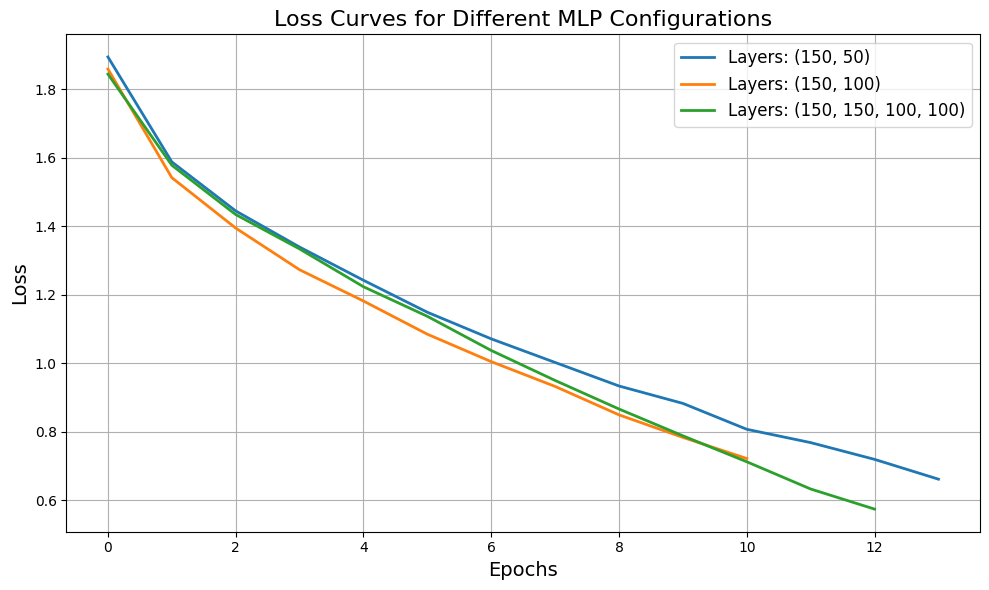

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))
for index, row in results_df.iterrows():
    ax.plot(row['loss_curve'], label=f"Layers: {row['Configuration']}", linewidth=2)
ax.set_title('Loss Curves for Different MLP Configurations', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.grid(True)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [138]:
display(results_df[['Configuration', 'Test Accuracy']])


,Configuration,Test Accuracy
0,"(150, 50)",45.82%
1,"(150, 100)",44.57%
2,"(150, 150, 100, 100)",45.45%


## Interpretation of MLP Experiments

Through various MLPClassifier configurations, the following patterns emerged:

- Model complexity grows with added neurons and layers, yet this doesn't consistently enhance test accuracy, hinting at potential overfitting risks with overly complex models.
- As expected, more complex models with additional neurons and layers require longer training times.
- Loss curves imply potential gains from additional epochs or alternative optimization methods, as suggested by convergence warnings; the optimization hasn't located the minimal loss yet.
- Smaller batch sizes introduce more fluctuation in training loss, while larger ones stabilize the loss curve but may hinder convergence to the global minimum.
- Tuning the learning rate is critical; too high can overshoot the minimum, and too low may slow convergence significantly.
- Striking a balance is crucial: models with increased depth and neurons learn complex patterns more effectively but may overfit and thus benefit from regularization strategies.

Further experimentation with batch size, learning rate adjustments, and regularization methods could yield a more optimal model for the CIFAR-10 dataset.


* <div style="color:blue">Visualize 12 misclassifications <b>and</b> state an opinion on these.</div>

In [139]:
# Your solution goes here: (if you need more code/markdown cells, feel free to insert them as you see fit)

import matplotlib.pyplot as plt
chosen_config = (128, 64)
mlp = MLPClassifier(hidden_layer_sizes=chosen_config, max_iter=100, learning_rate_init=0.01, batch_size=200, random_state=1)
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)

misclassified_indices = np.where(y_pred != y_test)[0]

np.random.seed(0)
selected_misclassified_indices = np.random.choice(misclassified_indices, 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(10, 8))  # 3x4 grid for 12 images
axes = axes.flatten() 

for i, idx in enumerate(selected_misclassified_indices):
    ax = axes[i]
    ax.imshow(X_test[idx].reshape(32, 32, 3), cmap='gray')
    ax.set_title(f"Pred: {y_pred[idx]}, True: {y_test[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()